In [4]:
# OPTIMIZED for RTX 5070 Ti (16GB VRAM)
from transformers import TrainingArguments, Trainer

percent_dataset = 10  # Use x% of dataset
args = TrainingArguments(
    output_dir="./outputs",
    num_train_epochs=12,  # Match paper
    
    # Batch size configuration
    per_device_train_batch_size=8,  # Smaller batch per GPU
    per_device_eval_batch_size=8,   # Can be larger during eval
    gradient_accumulation_steps=2,   # 8 × 2 = 16 (matches paper's effective batch size)
    
    # Evaluation and saving
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,  # Keep only best 3 checkpoints
    
    # Optimization
    learning_rate=1e-5,  # Paper typically uses 1e-4 for RT-DETR
    weight_decay=1e-4,
    warmup_steps=200,  # Warmup for stable training
    max_grad_norm=0.1,  # Gradient clipping
    
    # Performance optimization
    fp16=False,
    # dataloader_num_workers=4,  # Use multiple CPU cores for data loading
    dataloader_pin_memory=True,  # Faster data transfer to GPU
    
    # Logging and monitoring
    logging_steps=50,
    logging_first_step=True,
    report_to="tensorboard",
    
    # Model selection
    load_best_model_at_end=True,
    metric_for_best_model="map",
    greater_is_better=True,
    
    # Other settings
    seed=42,
    push_to_hub=False,
    remove_unused_columns=False,
    
    # Memory optimization
    optim="adamw_torch",  # Use PyTorch's AdamW (slightly more memory efficient)
)

In [5]:
import supervision as sv
import os
import numpy as np
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Load both datasets
COCO_DIR = "E:/Python/DLCV/Project/dataset/coco"
COCO_RAIN_DIR = "E:/Python/DLCV/Project/dataset/coco_rain"

# Load COCO dataset
ds_train_coco = sv.DetectionDataset.from_coco(
    images_directory_path=f"{COCO_DIR}/train2017",
    annotations_path=f"{COCO_DIR}/annotations/instances_train2017.json",
)

ds_valid_coco = sv.DetectionDataset.from_coco(
    images_directory_path=f"{COCO_DIR}/val2017",
    annotations_path=f"{COCO_DIR}/annotations/instances_val2017.json",
)

# Load COCO_rain dataset
ds_train_rain = sv.DetectionDataset.from_coco(
    images_directory_path=f"{COCO_RAIN_DIR}/train2017",
    annotations_path=f"{COCO_RAIN_DIR}/annotations/instances_train2017.json",
)

ds_valid_rain = sv.DetectionDataset.from_coco(
    images_directory_path=f"{COCO_RAIN_DIR}/val2017",
    annotations_path=f"{COCO_RAIN_DIR}/annotations/instances_val2017.json",
)

# Combine datasets with 80% COCO and 20% COCO_rain
coco_ratio = 0.8  # 80% COCO images
rain_ratio = 0.2  # 20% rain images

# IMPORTANT: COCO and COCO_rain have the same images (rain is augmented version)
# So we need to set the target size based on ONE dataset, not the sum
# Option 1: Use full COCO dataset as base size
target_train_size = len(ds_train_coco)  # ~118k
target_val_size = len(ds_valid_coco)    # ~5k

# Option 2: Or use a smaller subset (uncomment to use)
# target_train_size = 10000
# target_val_size = 1000

# Calculate how many samples from each dataset
coco_train_size = int(target_train_size * coco_ratio)
rain_train_size = int(target_train_size * rain_ratio)

coco_val_size = int(target_val_size * coco_ratio)
rain_val_size = int(target_val_size * rain_ratio)

print(f"Target combined training size: {coco_train_size + rain_train_size}")
print(f"  - COCO: {coco_train_size}")
print(f"  - COCO_rain: {rain_train_size}")
print(f"Target combined validation size: {coco_val_size + rain_val_size}")
print(f"  - COCO: {coco_val_size}")
print(f"  - COCO_rain: {rain_val_size}")

# Create random indices for sampling
np.random.seed(42)
coco_train_indices = np.random.choice(len(ds_train_coco), coco_train_size, replace=False)
rain_train_indices = np.random.choice(len(ds_train_rain), rain_train_size, replace=False)

coco_val_indices = np.random.choice(len(ds_valid_coco), coco_val_size, replace=False)
rain_val_indices = np.random.choice(len(ds_valid_rain), rain_val_size, replace=False)

# Subset datasets by filtering image paths
coco_train_paths = [ds_train_coco.image_paths[i] for i in coco_train_indices]
rain_train_paths = [ds_train_rain.image_paths[i] for i in rain_train_indices]

coco_val_paths = [ds_valid_coco.image_paths[i] for i in coco_val_indices]
rain_val_paths = [ds_valid_rain.image_paths[i] for i in rain_val_indices]

# Manually merge datasets (supervision's merge() has issues)
# Combine COCO and COCO_rain by concatenating paths and merging annotations
train_combined_paths = coco_train_paths + rain_train_paths
train_combined_annotations = {}
train_combined_annotations.update({path: ds_train_coco.annotations[path] for path in coco_train_paths})
train_combined_annotations.update({path: ds_train_rain.annotations[path] for path in rain_train_paths})

val_combined_paths = coco_val_paths + rain_val_paths
val_combined_annotations = {}
val_combined_annotations.update({path: ds_valid_coco.annotations[path] for path in coco_val_paths})
val_combined_annotations.update({path: ds_valid_rain.annotations[path] for path in rain_val_paths})

# Create merged datasets
ds_train = sv.DetectionDataset(
    classes=ds_train_coco.classes,
    images=train_combined_paths,
    annotations=train_combined_annotations
)

ds_valid = sv.DetectionDataset(
    classes=ds_valid_coco.classes,
    images=val_combined_paths,
    annotations=val_combined_annotations
)

print(f"✓ Combined datasets created:")
print(f"  Training: {len(ds_train)} images ({len(coco_train_paths)} COCO + {len(rain_train_paths)} COCO_rain)")
print(f"  Validation: {len(ds_valid)} images ({len(coco_val_paths)} COCO + {len(rain_val_paths)} COCO_rain)")
print(f"  Actual Training: {len(train_combined_paths)} total")
print(f"  Actual Validation: {len(val_combined_paths)} total")

Target combined training size: 118286
  - COCO: 94629
  - COCO_rain: 23657
Target combined validation size: 5000
  - COCO: 4000
  - COCO_rain: 1000
✓ Combined datasets created:
  Training: 118286 images (94629 COCO + 23657 COCO_rain)
  Validation: 5000 images (4000 COCO + 1000 COCO_rain)
  Actual Training: 118286 total
  Actual Validation: 5000 total


In [6]:
import albumentations as A

augmentation_train = A.Compose(
    [
        A.Perspective(p=0.1, scale=(0.05, 0.1)),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.1),
    ],
    bbox_params=A.BboxParams(
        format="pascal_voc",  # xyxy
        label_fields=["category"],
        min_area=25,
        min_visibility=0.3,  # Drop boxes with low overlap after transform
        clip=True
    ),
)

augmentation_valid = A.Compose(
    [A.NoOp()],
    bbox_params=A.BboxParams(format="pascal_voc", label_fields=["category"], clip=True, min_area=1),
)

In [7]:
from torch.utils.data import Dataset
import numpy as np
from transformers import RTDetrImageProcessor
import torch
import cv2

class AugmentedDetectionDataset(Dataset):
    def __init__(self, dataset, processor, transform, is_train=True):
        self.dataset = dataset
        self.processor = processor
        self.transform = transform
        self.is_train = is_train

    @staticmethod
    def annotations_as_coco(image_id, categories, areas, boxes):
        annotations = []
        for category, area, box in zip(categories, areas, boxes):
            x_min, y_min, x_max, y_max = box
            width = x_max - x_min
            height = y_max - y_min
            
            if width <= 0 or height <= 0:
                continue
                
            annotations.append({
                "image_id": image_id,
                "category_id": int(category),
                "iscrowd": 0,
                "area": area if area else width * height,
                "bbox": [x_min, y_min, width, height],
            })
        return {"image_id": image_id, "annotations": annotations}
    
    @staticmethod
    def validate_bbox(box, min_size=10):
        """Validate bounding box dimensions"""
        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1
        
        # Check for valid dimensions
        if width < min_size or height < min_size:
            return False
        if x1 < 0 or y1 < 0:
            return False
        if x2 <= x1 or y2 <= y1:
            return False
        if np.isnan(box).any() or np.isinf(box).any():
            return False
        
        return True

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Retry logic for bad samples
        max_retries = 5
        for attempt in range(max_retries):
            try:
                return self._get_item_internal(idx)
            except (ValueError, AssertionError) as e:
                if attempt < max_retries - 1:
                    # Try next index if current one fails
                    idx = (idx + 1) % len(self.dataset)
                    continue
                else:
                    # Last attempt failed, return a dummy sample
                    print(f"Warning: Failed to load sample after {max_retries} attempts. Creating dummy sample.")
                    return self._create_dummy_sample()
    
    def _create_dummy_sample(self):
        """Create a valid dummy sample when real data fails"""
        # Create a simple image
        dummy_image = np.ones((640, 640, 3), dtype=np.uint8) * 128
        
        # Create a valid center box
        dummy_box = [[256, 256, 384, 384]]  # Center box
        dummy_category = [0]
        dummy_area = [128 * 128]
        
        formatted_annotations = self.annotations_as_coco(0, dummy_category, dummy_area, dummy_box)
        result = self.processor(images=dummy_image, annotations=formatted_annotations, return_tensors="pt")
        
        result["pixel_values"] = result["pixel_values"].squeeze(0)
        if "pixel_mask" in result:
            result["pixel_mask"] = result["pixel_mask"].squeeze(0)
        result["labels"] = result["labels"][0]
        result["labels"]["orig_size"] = torch.tensor([640, 640], dtype=torch.int64)
        
        return result

    def _get_item_internal(self, idx):
        image_id, image, annotations = self.dataset[idx]
        if image is None:
            raise ValueError(f"Image not loaded for index {idx} (image_id: {image_id}).")
        
        # Ensure image is RGB
        if len(image.shape) == 3 and image.shape[2] == 3:
            image = np.array(image)
        else:
            image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)
        
        orig_height, orig_width = image.shape[:2]
        
        # PRE-FILTER: Remove invalid boxes BEFORE augmentation
        valid_indices = []
        for i, box in enumerate(annotations.xyxy):
            if self.validate_bbox(box, min_size=10):
                valid_indices.append(i)
        
        if len(valid_indices) == 0:
            # No valid boxes, create a dummy one
            h, w = image.shape[:2]
            valid_boxes = np.array([[w*0.4, h*0.4, w*0.6, h*0.6]])
            valid_categories = np.array([0])
        else:
            valid_boxes = annotations.xyxy[valid_indices]
            valid_categories = annotations.class_id[valid_indices]
        
        # Apply transformations with valid boxes only
        transformed = self.transform(
            image=image,
            bboxes=valid_boxes,
            category=valid_categories
        )
        
        image = transformed["image"]
        boxes = transformed["bboxes"]
        categories = transformed["category"]
        
        # POST-FILTER: Validate boxes after transformation
        final_boxes = []
        final_categories = []
        
        h, w = image.shape[:2]
        for box, cat in zip(boxes, categories):
            x1, y1, x2, y2 = box
            
            # Clip to image boundaries
            x1 = max(0, min(x1, w - 1))
            y1 = max(0, min(y1, h - 1))
            x2 = max(0, min(x2, w))
            y2 = max(0, min(y2, h))
            
            # Validate after clipping
            if self.validate_bbox([x1, y1, x2, y2], min_size=10):
                final_boxes.append([x1, y1, x2, y2])
                final_categories.append(cat)
        
        # Ensure we have at least one box
        if len(final_boxes) == 0:
            h, w = image.shape[:2]
            final_boxes = [[w*0.4, h*0.4, w*0.6, h*0.6]]
            final_categories = [0]
        
        boxes = final_boxes
        categories = final_categories
        
        # Calculate areas
        areas = [(box[2] - box[0]) * (box[3] - box[1]) for box in boxes]
        areas = [max(area, 100.0) for area in areas]  # Minimum area
        
        # Format annotations for processor
        formatted_annotations = self.annotations_as_coco(idx, categories, areas, boxes)
        
        # Process with HuggingFace processor
        result = self.processor(images=image, annotations=formatted_annotations, return_tensors="pt")
        
        # Squeeze batch dimensions
        result["pixel_values"] = result["pixel_values"].squeeze(0)
        if "pixel_mask" in result:
            result["pixel_mask"] = result["pixel_mask"].squeeze(0)
        result["labels"] = result["labels"][0]
        
        # Add original size for post-processing
        h, w = image.shape[:2]
        result["labels"]["orig_size"] = torch.tensor([h, w], dtype=torch.int64)
        
        # Final validation
        if torch.isnan(result["pixel_values"]).any():
            raise ValueError(f"NaN detected in pixel_values at index {idx}")
        if "boxes" in result["labels"] and len(result["labels"]["boxes"]) > 0:
            if torch.isnan(result["labels"]["boxes"]).any():
                raise ValueError(f"NaN detected in boxes at index {idx}")
        
        return result

# Load processor
processor = RTDetrImageProcessor.from_pretrained("PekingU/rtdetr_r50vd")

split_ratio = percent_dataset / 100
# Create datasets
train_subset, _ = ds_train.split(split_ratio=split_ratio)
valid_subset, _ = ds_valid.split(split_ratio=split_ratio)
train_dataset = AugmentedDetectionDataset(train_subset, processor, augmentation_train)
valid_dataset = AugmentedDetectionDataset(valid_subset, processor, augmentation_valid, is_train=False)

print(f"✓ Datasets created")
print(f"  Training samples: {len(train_dataset):,}")
print(f"  Validation samples: {len(valid_dataset):,}")

✓ Datasets created
  Training samples: 11,828
  Validation samples: 500


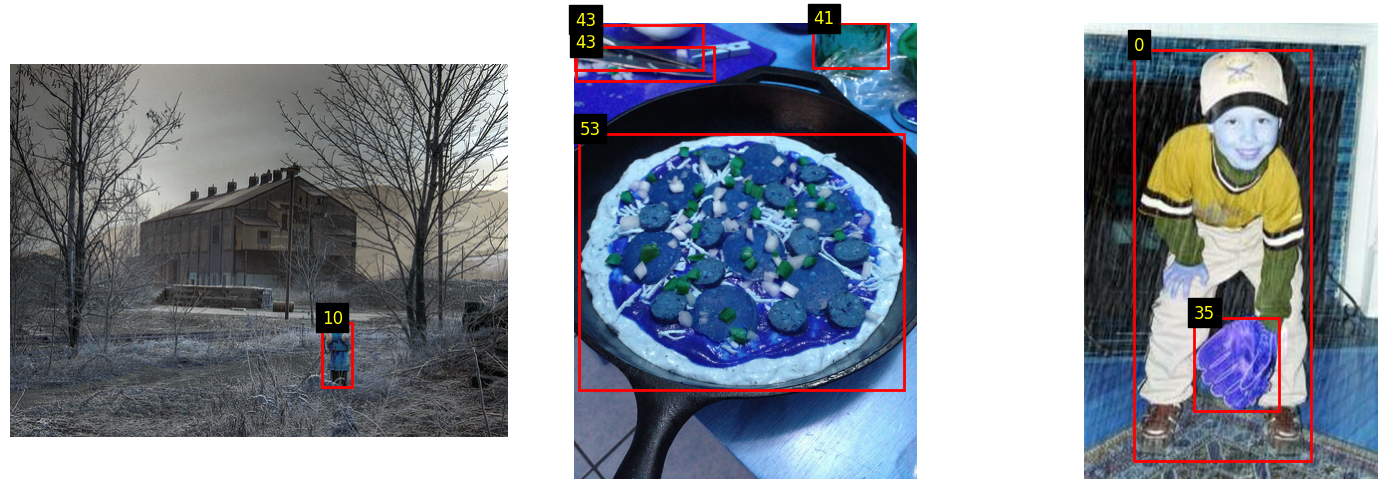

In [8]:
import random
import matplotlib.pyplot as plt

# Visualize a few images from train_dataset with their bounding boxes
num_samples = 3
indices = random.sample(range(len(train_dataset)), num_samples)

fig, axes = plt.subplots(1, num_samples, figsize=(5 * num_samples, 5))
if num_samples == 1:
    axes = [axes]

for ax, idx in zip(axes, indices):
    sample = train_dataset.dataset[idx]
    image = sample[1]
    ann = sample[2]
    boxes = ann.xyxy
    labels = ann.class_id

    ax.imshow(image)
    for box, label in zip(boxes, labels):
        x_min, y_min, x_max, y_max = box
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                             fill=False, color='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(x_min, y_min, str(label), color='yellow', fontsize=12, backgroundcolor='black')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [9]:
from transformers import RTDetrImageProcessor, RTDetrConfig, RTDetrForObjectDetection
# Pre-trained model loading (commented out)

# Load model with proper configuration
model_name = "PekingU/rtdetr_r18vd"

config = RTDetrConfig.from_pretrained(model_name)
config.num_labels = 80  # COCO classes

model = RTDetrForObjectDetection.from_pretrained(
    model_name,
    config=config,
    ignore_mismatched_sizes=False
)

# # Freeze backbone parameters
# for name, p in model.named_parameters():
#     if "backbone" in name:
#         p.requires_grad = False

# # Freeze BatchNorm running stats
# import torch.nn as nn
# for m in model.modules():
#     if isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d, nn.LayerNorm)):
#         m.eval()
#         for p in m.parameters():
#             p.requires_grad = False

In [10]:
# from transformers import RTDetrImageProcessor, RTDetrConfig, RTDetrForObjectDetection
# print("Creating RT-DETR with paper's configuration + pretrained backbone")

# # Create processor with paper's settings
# processor = RTDetrImageProcessor(
#     format="coco_detection",
#     do_resize=True,
#     size={"shortest_edge": 640, "longest_edge": 640},
# )

# # Paper's exact configuration
# config = RTDetrConfig(
#     # Backbone
#     # backbone="resnet50",
#     # use_pretrained_backbone=True,  # Use ImageNet pretrained weights
#     num_labels=80,  # COCO classes
    
#     # Architecture (from paper's table)
#     encoder_layers=1,  # number of AIFI layers
#     decoder_layers=3,  # number of decoder layers
#     num_queries=300,  # number of queries
#     decoder_n_points=4,  # decoder npoints
    
#     # Dimensions (from paper's table)
#     d_model=256,  # embedding dim
#     encoder_ffn_dim=1024,  # feedforward dim
#     decoder_ffn_dim=1024,  # feedforward dim
#     encoder_attention_heads=8,  # nheads
#     decoder_attention_heads=8,  # nheads
    
#     # Feature scales (from paper's table)
#     num_feature_levels=3,  # number of feature scales
#     # RepBlocks is handled by the backbone configuration
    
#     # Loss weights (from paper's table)
#     class_cost=2.0,  # class cost weight
#     bbox_cost=5.0,   # bbox cost weight
#     giou_cost=2.0,   # GIoU cost weight
    
#     # Loss coefficients (alpha, gamma from paper)
#     focal_alpha=0.25,  # α in class cost
#     # gamma is typically fixed at 2.0 for focal loss
    
#     # Class loss weight (from paper)
#     weight_dict={
#         "loss_vfl": 1.0,      # class loss weight
#         "loss_bbox": 5.0,     # bbox loss weight  
#         "loss_giou": 2.0,     # GIoU loss weight
#     },
    
#     # Denoising (from paper's table)
#     num_denoising=200,  # denoising groups
#     label_noise_ratio=0.5,  # label noise ratio
#     box_noise_scale=1.0,    # box noise scale
    
#     # Initialization
#     init_std=0.02,
#     init_xavier_std=1.0,
    
#     # Backbone specific
#     use_timm_backbone=False,
#     freeze_bn=True,  # freezing BN from paper
# )

# # Create model with pretrained backbone
# model = RTDetrForObjectDetection(config)

# # Print model info
# total_params = sum(p.numel() for p in model.parameters())
# backbone_params = sum(p.numel() for n, p in model.named_parameters() if 'backbone' in n)
# detection_params = total_params - backbone_params

# print(f"  Total parameters: {total_params:,} (~{total_params/1e6:.1f}M)")
# print(f"    - Backbone params: {backbone_params:,} (~{backbone_params/1e6:.1f}M)")
# print(f"    - Detection head params: {detection_params:,} (~{detection_params/1e6:.1f}M)")
# print(f"\nArchitecture:")
# print(f"  Encoder layers (AIFI): {config.encoder_layers}")
# print(f"  Decoder layers: {config.decoder_layers}")
# print(f"  Num queries: {config.num_queries}")
# print(f"  Feature levels: {config.num_feature_levels}")
# print(f"  Embedding dim: {config.d_model}")

In [11]:
total = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{trainable}/{total} trainable params ({trainable/total:.2%})")

20174608/20174608 trainable params (100.00%)


In [12]:
from dataclasses import dataclass
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from transformers.image_transforms import center_to_corners_format
from transformers.trainer_utils import EvalLoopOutput
import torch
import numpy as np

@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor

class ObjectDetectionTrainer(Trainer):
    """Custom Trainer for object detection that properly handles predictions"""
    
    def evaluation_loop(self, dataloader, description, prediction_loss_only=None, ignore_keys=None, metric_key_prefix="eval"):
        model = self.model
        model.eval()
        
        all_logits = []
        all_pred_boxes = []
        all_labels = []
        total_loss = 0.0
        num_batches = 0
        
        for step, inputs in enumerate(dataloader):
            inputs = self._prepare_inputs(inputs)
            
            with torch.no_grad():
                outputs = model(**inputs)
            
            if outputs.loss is not None:
                total_loss += outputs.loss.item()
                num_batches += 1
            
            all_logits.append(outputs.logits.detach().cpu())
            all_pred_boxes.append(outputs.pred_boxes.detach().cpu())
            
            labels = inputs.get("labels")
            if labels is not None:
                for label in labels:
                    if hasattr(label, 'data'):
                        all_labels.append(dict(label.data))
                    elif isinstance(label, dict):
                        all_labels.append(label)
                    else:
                        all_labels.append(dict(label))
        
        logits = torch.cat(all_logits, dim=0)
        pred_boxes = torch.cat(all_pred_boxes, dim=0)
        
        metrics = {}
        if self.compute_metrics is not None:
            from transformers.trainer_utils import EvalPrediction
            eval_pred = EvalPrediction(predictions=(logits, pred_boxes), label_ids=all_labels)
            metrics = self.compute_metrics(eval_pred)
        
        if num_batches > 0:
            metrics["loss"] = total_loss / num_batches
        
        metrics = {f"{metric_key_prefix}_{k}": v for k, v in metrics.items()}
        
        return EvalLoopOutput(
            predictions=(logits.numpy(), pred_boxes.numpy()),
            label_ids=all_labels,
            metrics=metrics,
            num_samples=len(all_labels)
        )

@torch.no_grad()
def compute_metrics(eval_pred, processor, threshold=0.5):
    """Compute mAP metrics"""
    predictions, targets = eval_pred.predictions, eval_pred.label_ids
    
    if predictions is None or targets is None:
        return {"map": 0.0}
    
    try:
        if isinstance(predictions, (tuple, list)) and len(predictions) == 2:
            logits, pred_boxes = predictions
            
            if isinstance(logits, np.ndarray):
                logits = torch.from_numpy(logits)
            if isinstance(pred_boxes, np.ndarray):
                pred_boxes = torch.from_numpy(pred_boxes)
        else:
            return {"map": 0.0}
        
        if logits.shape[0] != len(targets):
            return {"map": 0.0}
        
        # Process targets
        image_sizes = []
        post_processed_targets = []
        
        for target in targets:
            if hasattr(target, 'data'):
                target = dict(target.data)
            elif not isinstance(target, dict):
                target = dict(target)
            
            if "orig_size" not in target:
                continue
            
            orig_size = target["orig_size"]
            if isinstance(orig_size, np.ndarray):
                orig_size = torch.from_numpy(orig_size)
            elif not isinstance(orig_size, torch.Tensor):
                orig_size = torch.tensor(orig_size)
            orig_size = orig_size.cpu()
            image_sizes.append(orig_size)
            
            if "boxes" in target and "class_labels" in target and len(target["boxes"]) > 0:
                gt_boxes = target["boxes"]
                gt_labels = target["class_labels"]
                
                if isinstance(gt_boxes, np.ndarray):
                    gt_boxes = torch.from_numpy(gt_boxes)
                elif not isinstance(gt_boxes, torch.Tensor):
                    gt_boxes = torch.tensor(gt_boxes)
                    
                if isinstance(gt_labels, np.ndarray):
                    gt_labels = torch.from_numpy(gt_labels)
                elif not isinstance(gt_labels, torch.Tensor):
                    gt_labels = torch.tensor(gt_labels)
                
                gt_boxes = gt_boxes.cpu()
                gt_labels = gt_labels.cpu()
                
                # Convert from normalized cxcywh to absolute xyxy
                gt_boxes_xyxy = center_to_corners_format(gt_boxes.clone())
                gt_boxes_xyxy[:, 0::2] *= orig_size[1]
                gt_boxes_xyxy[:, 1::2] *= orig_size[0]
                
                # Validate boxes
                valid_mask = (gt_boxes_xyxy[:, 2] > gt_boxes_xyxy[:, 0]) & \
                            (gt_boxes_xyxy[:, 3] > gt_boxes_xyxy[:, 1])
                
                if valid_mask.sum() > 0:
                    post_processed_targets.append({
                        "boxes": gt_boxes_xyxy[valid_mask].cpu(),
                        "labels": gt_labels[valid_mask].cpu()
                    })
                else:
                    post_processed_targets.append({
                        "boxes": torch.empty((0, 4)),
                        "labels": torch.empty((0,), dtype=torch.long)
                    })
            else:
                post_processed_targets.append({
                    "boxes": torch.empty((0, 4)),
                    "labels": torch.empty((0,), dtype=torch.long)
                })
        
        if len(image_sizes) == 0:
            return {"map": 0.0}
        
        image_sizes = torch.stack(image_sizes)
        
        # Post-process predictions
        output = ModelOutput(logits=logits, pred_boxes=pred_boxes)
        post_processed_predictions = processor.post_process_object_detection(
            output, threshold=threshold, target_sizes=image_sizes
        )
        
        # Move predictions to CPU
        for pred in post_processed_predictions:
            pred['boxes'] = pred['boxes'].cpu()
            pred['scores'] = pred['scores'].cpu()
            pred['labels'] = pred['labels'].cpu()
        
        total_gt = sum(len(t['boxes']) for t in post_processed_targets)
        
        if total_gt == 0:
            return {"map": 0.0}
        
        # Compute mAP
        metric = MeanAveragePrecision(box_format="xyxy", class_metrics=False)
        metric.update(post_processed_predictions, post_processed_targets)
        metrics = metric.compute()
        
        map_value = metrics["map"].item() if "map" in metrics else 0.0
        
        return {"map": map_value}
        
    except Exception as e:
        return {"map": 0.0}

def collate_fn(batch):
    data = {}
    data["pixel_values"] = torch.stack([x["pixel_values"] for x in batch])
    data["labels"] = [x["labels"] for x in batch]
    if "pixel_mask" in batch[0]:
        data["pixel_mask"] = torch.stack([x["pixel_mask"] for x in batch])
    return data

trainer = ObjectDetectionTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=processor,
    data_collator=collate_fn,
    compute_metrics=lambda eval_pred: compute_metrics(eval_pred, processor=processor, threshold = 0.3),
)

In [13]:
trainer.train()  # Runs training; auto-evals on val

Epoch,Training Loss,Validation Loss,Map
1,9.822400,6.297300,0.340947
2,9.792700,6.384001,0.335032
3,9.548400,6.452044,0.328750
4,9.429600,6.498499,0.328489
5,9.364300,6.491047,0.329550
6,9.418600,6.517515,0.326013
7,9.316500,6.531442,0.328144
8,9.281700,6.540307,0.335817
9,9.183500,6.571121,0.329359
10,9.115500,6.608930,0.320775


There were missing keys in the checkpoint model loaded: ['class_embed.0.weight', 'class_embed.0.bias', 'class_embed.1.weight', 'class_embed.1.bias', 'class_embed.2.weight', 'class_embed.2.bias', 'bbox_embed.0.layers.0.weight', 'bbox_embed.0.layers.0.bias', 'bbox_embed.0.layers.1.weight', 'bbox_embed.0.layers.1.bias', 'bbox_embed.0.layers.2.weight', 'bbox_embed.0.layers.2.bias', 'bbox_embed.1.layers.0.weight', 'bbox_embed.1.layers.0.bias', 'bbox_embed.1.layers.1.weight', 'bbox_embed.1.layers.1.bias', 'bbox_embed.1.layers.2.weight', 'bbox_embed.1.layers.2.bias', 'bbox_embed.2.layers.0.weight', 'bbox_embed.2.layers.0.bias', 'bbox_embed.2.layers.1.weight', 'bbox_embed.2.layers.1.bias', 'bbox_embed.2.layers.2.weight', 'bbox_embed.2.layers.2.bias'].


TrainOutput(global_step=8880, training_loss=9.473785474278905, metrics={'train_runtime': 4935.7008, 'train_samples_per_second': 28.757, 'train_steps_per_second': 1.799, 'total_flos': 2.1090336592468378e+19, 'train_loss': 9.473785474278905, 'epoch': 12.0})

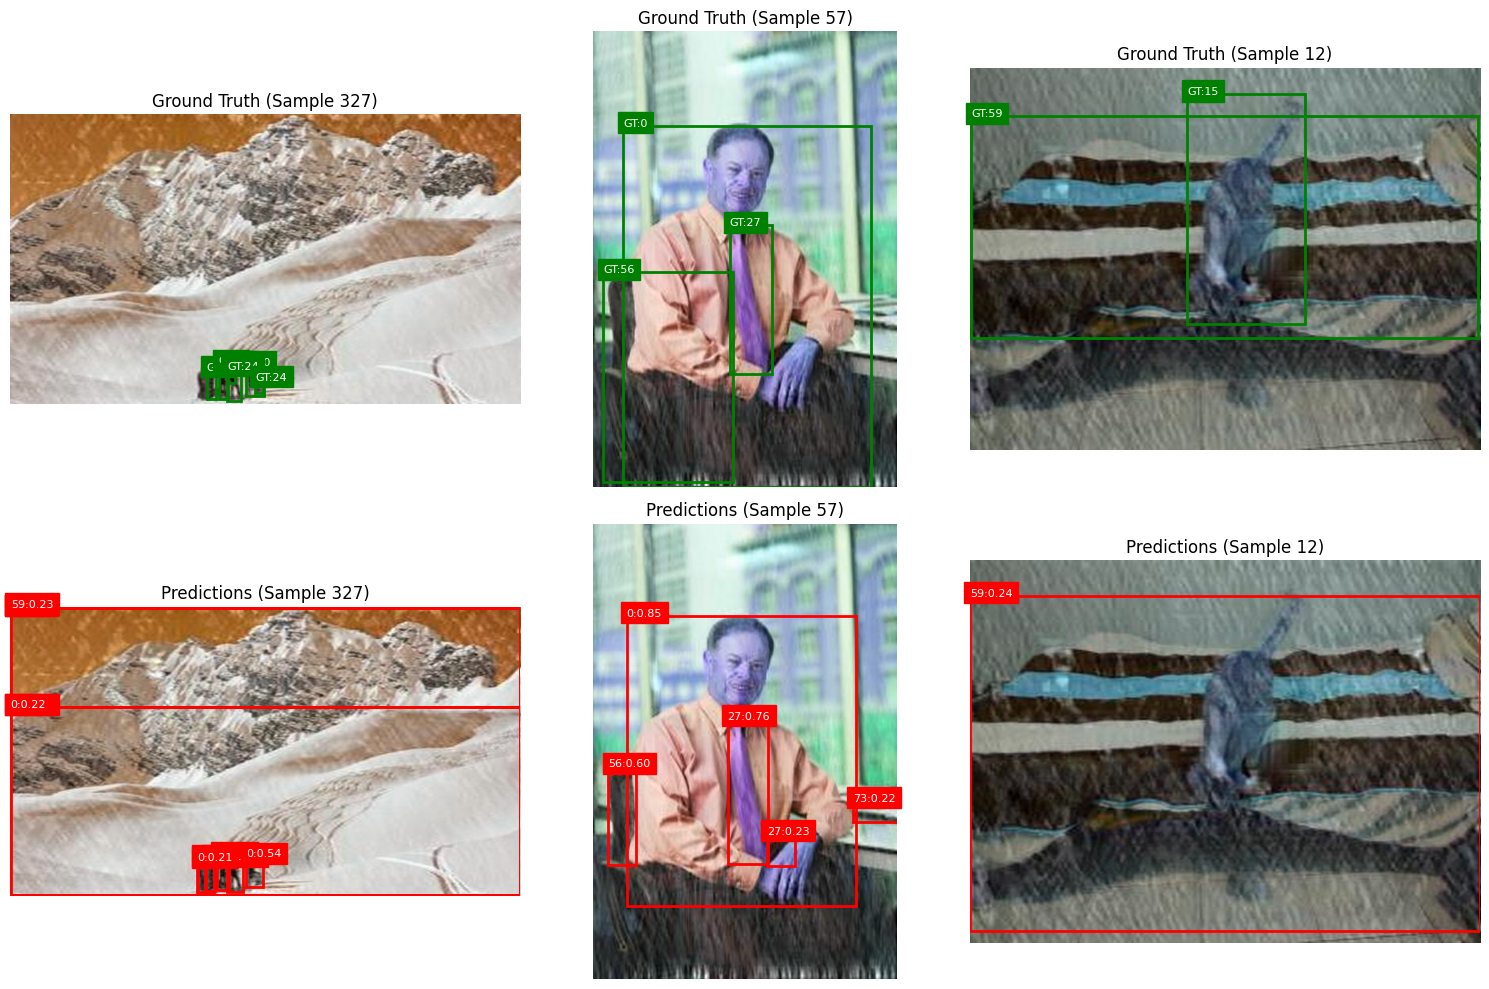

In [ ]:
import matplotlib.pyplot as plt
import random
import torch

def visualize_predictions(model, dataset, processor, num_samples=3, threshold=0.3):
    """Visualize model predictions vs ground truth"""
    device = next(model.parameters()).device
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    fig, axes = plt.subplots(2, num_samples, figsize=(5 * num_samples, 10))
    if num_samples == 1:
        axes = axes.reshape(-1, 1)
    
    model.eval()
    
    for col, idx in enumerate(indices):
        sample = dataset[idx]
        pixel_values = sample["pixel_values"].unsqueeze(0).to(device)
        labels = sample["labels"]
        
        original_sample = dataset.dataset[idx]
        image = original_sample[1]
        
        with torch.no_grad():
            outputs = model(pixel_values)
        
        target_size = labels["orig_size"].unsqueeze(0)
        post_processed = processor.post_process_object_detection(
            outputs, threshold=threshold, target_sizes=target_size
        )
        predictions = post_processed[0]
        
        # Plot ground truth
        axes[0, col].imshow(image)
        axes[0, col].set_title(f"Ground Truth (Sample {idx})")
        
        if "boxes" in labels and len(labels["boxes"]) > 0:
            gt_boxes = labels["boxes"]
            gt_labels = labels["class_labels"]
            
            for box, label in zip(gt_boxes, gt_labels):
                if box.max() <= 1.0:
                    h, w = image.shape[:2]
                    cx, cy, bw, bh = box
                    x1, y1 = (cx - bw/2) * w, (cy - bh/2) * h
                    x2, y2 = (cx + bw/2) * w, (cy + bh/2) * h
                else:
                    x1, y1, x2, y2 = box
                
                rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                   fill=False, color='green', linewidth=2)
                axes[0, col].add_patch(rect)
                axes[0, col].text(x1, y1, f"GT:{int(label)}", 
                                color='white', fontsize=8, backgroundcolor='green')
        
        # Plot predictions
        axes[1, col].imshow(image)
        axes[1, col].set_title(f"Predictions (Sample {idx})")
        
        pred_boxes = predictions["boxes"].cpu()
        pred_scores = predictions["scores"].cpu()
        pred_labels = predictions["labels"].cpu()
        
        for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
            if score > threshold:
                x1, y1, x2, y2 = box
                rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                   fill=False, color='red', linewidth=2)
                axes[1, col].add_patch(rect)
                axes[1, col].text(x1, y1, f"{int(label)}:{score:.2f}", 
                                color='white', fontsize=8, backgroundcolor='red')
        
        for row in range(2):
            axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize results
visualize_predictions(model, valid_dataset, processor, num_samples=3, threshold=0.2)

In [ ]:
best = trainer.state.best_model_checkpoint
if best:
    trainer.save_model("outputs/best_from_training")  # or copy from `best`

Epochs found: 12
training_loss: [11.9751 11.5779 11.2367 11.3938 11.3726 11.2477 11.0613 11.157  11.0521
 11.3785 11.1487 11.2604]
val_loss: [7.26972147 7.19908693 7.16332931 7.17279596 7.20245478 7.16924041
 7.19804625 7.23666747 7.2478117  7.23097041 7.23617116 7.21234722]
val_map: [0.27297279 0.27419493 0.26897448 0.25905192 0.24751972 0.23616485
 0.23060399 0.22695769 0.22168013 0.21845409 0.21994424 0.2166381 ]


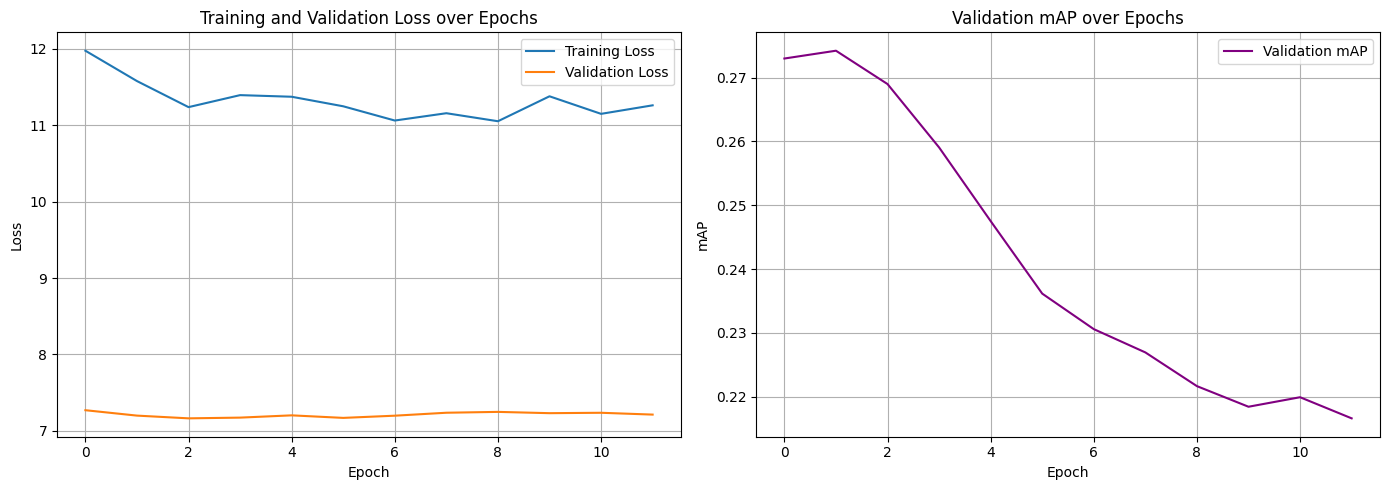

In [ ]:
# Build epoch-level arrays for training loss, validation loss and mAP
import numpy as np
import matplotlib.pyplot as plt

# Initialize arrays using the number of epochs in args (fallback to 0 if missing)
num_epochs = int(getattr(args, 'num_train_epochs', 0))
training_loss = np.full(num_epochs, np.nan)
val_loss = np.full(num_epochs, np.nan)
val_map = np.full(num_epochs, np.nan)

log_history = trainer.state.log_history

# Iterate through log history and pick only epoch-level eval entries that contain 'eval_map'
for i, entry in enumerate(log_history):
    # Skip entries without an 'epoch' key
    if 'epoch' not in entry:
        continue

    # Make sure epoch is numeric and integer-valued (e.g., 1.0, 2.0)
    try:
        epoch_val = float(entry['epoch'])
    except Exception:
        continue

    if not epoch_val.is_integer():
        # skip intermediate/step entries
        continue

    epoch_idx = int(epoch_val) - 1  # zero-based index
    if epoch_idx < 0 or epoch_idx >= num_epochs:
        # Out-of-range epoch (safety)
        continue

    # We're interested in evaluation entries that include 'eval_map'
    if 'eval_map' in entry:
        val_map[epoch_idx] = float(entry.get('eval_map', np.nan))
        val_loss[epoch_idx] = float(entry.get('eval_loss', np.nan))

        # Find the most recent training 'loss' entry before this eval
        # Walk backwards from the current log position
        found_loss = False
        for j in range(i - 1, -1, -1):
            prev = log_history[j]
            if 'loss' in prev:
                try:
                    training_loss[epoch_idx] = float(prev['loss'])
                    found_loss = True
                    break
                except Exception:
                    continue
        if not found_loss:
            # As a fallback, try any loss keyed to the same epoch (if exists later)
            for prev in log_history:
                if prev.get('epoch') and float(prev['epoch']).is_integer() and prev.get('epoch') == epoch_val and 'loss' in prev:
                    try:
                        training_loss[epoch_idx] = float(prev['loss'])
                        break
                    except Exception:
                        continue

# Optionally trim trailing NaNs (if training didn't finish all epochs)
valid_epochs = ~np.isnan(val_map) | ~np.isnan(training_loss) | ~np.isnan(val_loss)
if valid_epochs.sum() > 0:
    # Use only epochs that have at least one recorded metric
    training_loss = training_loss[valid_epochs]
    val_loss = val_loss[valid_epochs]
    val_map = val_map[valid_epochs]
else:
    # If nothing found, keep arrays sized by num_epochs but warn
    print('Warning: no epoch-level eval entries with \"eval_map\" found in trainer.state.log_history')

# Quick print to confirm
print('Epochs found:', len(val_map))
print('training_loss:', training_loss)
print('val_loss:', val_loss)
print('val_map:', val_map)

# Plotting (same as before)
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Loss subplot
if len(training_loss) > 0:
    axs[0].plot(training_loss, label='Training Loss')
if len(val_loss) > 0:
    axs[0].plot(val_loss, label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].grid(True)

# mAP subplot
if len(val_map) > 0:
    axs[1].plot(val_map, label='Validation mAP', color='purple')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('mAP')
axs[1].legend()
axs[1].set_title('Validation mAP over Epochs')
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
torch.cuda.empty_cache()

In [ ]:
Te = 0.05*11594
m = 40* 1e-3 / 6.022e23
kb = 1.38 * 10**-23
v = np.sqrt(kb*Te/m)

print(v/1e2)

3.470416290591087
